In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
movil = pd.read_csv('datasets/Telefonia_movil.csv', dayfirst=True, thousands='.')
movil.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
17,2017,2,15315167,6293563,21608730,Abr-Jun 2017
18,2017,3,15106275,6308373,21414647,Jul-Sept 2017
19,2017,4,14164552,5380710,19545262,Oct-Dic 2017
20,2018,1,13851254,5958717,19809971,Ene-Mar 2018
21,2018,2,14388755,6290155,20678910,Abr-Jun 2018


In [58]:

movil.index = pd.PeriodIndex((movil["Año"].astype(str) + "Q" + movil["Trimestre"].astype(str)), freq="Q")

In [59]:
movil

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2013Q1,2013,1,8785943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2013Q3,2013,3,10315484,7335154,17650638,Jul-Sept 2013
2013Q4,2013,4,9809515,6250549,16060064,Oct-Dic 2013
2014Q1,2014,1,10128751,5799223,15927974,Ene-Mar 2013
2014Q2,2014,2,10821463,6438071,17259534,Abr-Jun 2014
2014Q3,2014,3,11524344,7179152,18703495,Jul-Sept 2014
2014Q4,2014,4,11997330,7147630,19144961,Oct-Dic 2014
2015Q1,2015,1,10273637,6480172,16753809,Ene-Mar 2015
2015Q2,2015,2,11226576,6579819,17806395,Abr-Jun 2015


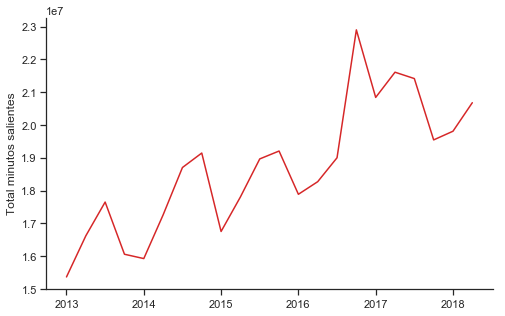

In [60]:
y = movil['Total de minutos salientes (miles)']

fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Total minutos salientes')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

In [61]:
y.describe().round(2)

count          22.00
mean     18701180.05
std       1990542.72
min      15368060.00
25%      17357310.00
50%      18834516.00
75%      19743793.75
max      22899656.00
Name: Total de minutos salientes (miles), dtype: float64

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [62]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q3    20678910
2018Q4    20678910
2019Q1    20678910
2019Q2    20678910
Freq: Q-DEC, dtype: int64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [63]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1464911.401

Using the formulas from the lecture, the interval forecasts are as below. 

In [64]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q3,1.780774e+07,2.355008e+07
2018Q4,1.661846e+07,2.473936e+07
2019Q1,1.570589e+07,2.565193e+07
2019Q2,1.493656e+07,2.642126e+07


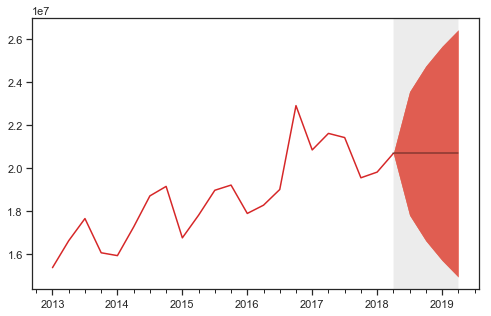

In [77]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2013':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

The exponential smoothing functions are available in the latest stable version (0.9) of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [69]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
# model_ses.summary() # summary isn't implemented in 0.9, looks it'll be avaible in 0.10
alpha_ses = model_ses.model.params['smoothing_level']
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
# loglik_ses = model_ses.model.loglike(model_ses.model.params) # NotImplementedError
aic_ses = model_ses.aic
bic_ses = model_ses.bic
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_ses))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))


 Smoothing parameter: alpha  0.535
 In-sample fit:
 MSE               1843938379587.524
 AIC               625.344
 BIC               627.526


Also AIC and BIC looks off so we are continue our analysis with MSE. Also they are fixed in 0.10. In the case you need them, you can calculate them as it follows

In [70]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -341.889
 AIC               689.778
 BIC               693.051


Now, let's see how the smoothed data fits the original data

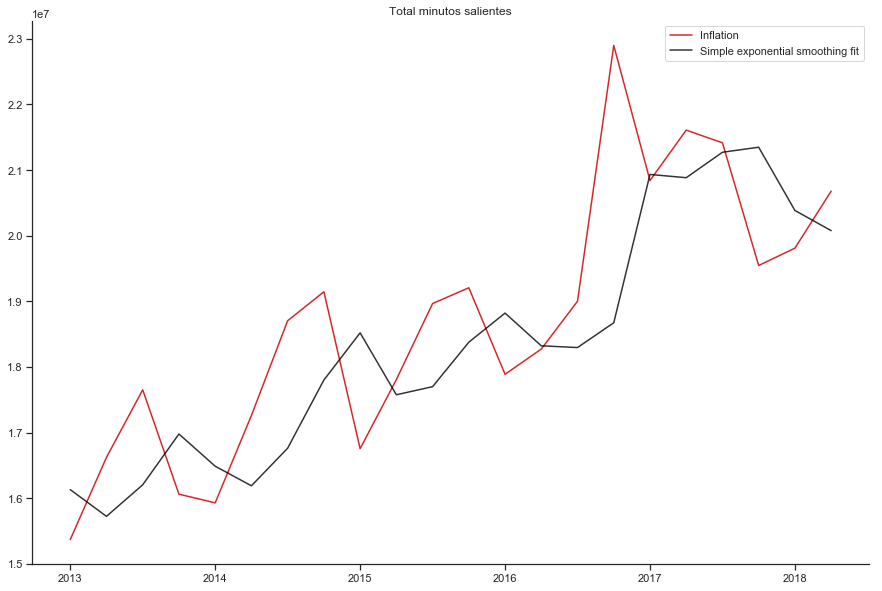

In [78]:
fig, ax= plt.subplots(figsize=(15,10))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_title('Total minutos salientes')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [72]:
resid=y-fitted_ses # model_ses.resid isn't a panda.Series, so no index, no plot

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

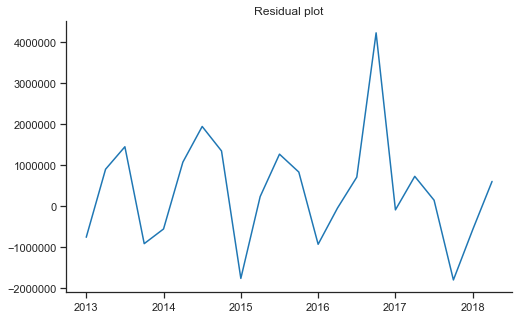

In [73]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Next is the residual ACF plot aka correlogram

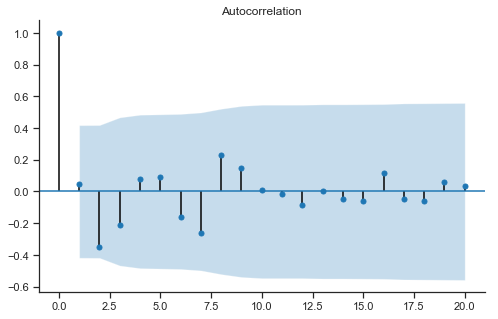

In [74]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

C:\Users\franc\Anaconda3\envs\diplomatura\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


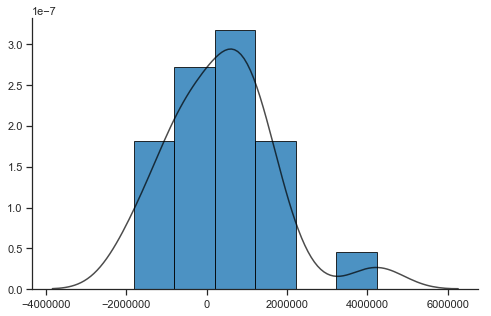

In [75]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [110]:
# Real time forecasting - use it as a template - expanding window

validation=y['2013Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2013Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

ValueError: negative dimensions are not allowed

We find that simple exponential smoothing generates more accurate forecasts. 

In [20]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,0.518,0.068
SES,0.446,0.059


## Forecast

We show how to do expanding and rolling point forecast. 

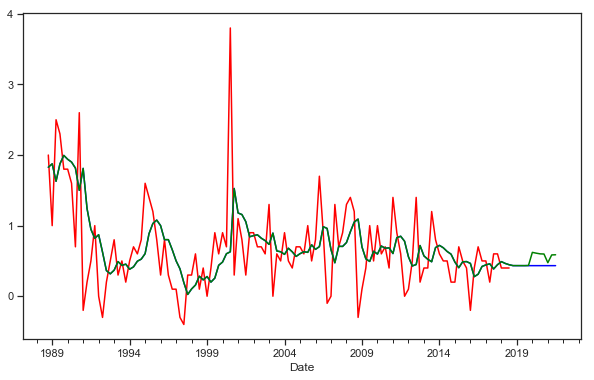

In [26]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(10,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

In this case, **statsmodels** doesn't provide interval forecast